In [1]:
# This notebook will contain the step-by-step procedures and explanations. Code here has been take from the notebook titled 'fyp_model_testing.ipynb' 
# Author: Swapnil Joshi
# Latest date of modification: April 16 2022, 10:33am

# **INSTALLING THE REQUIRED LIBRARIES**


In [2]:
#Just change the pip command to install any libraries

!pip install tvdatafeed #for the datafeed
!pip install vectorbt #for main backtesting engine

     |████████████████████████████████| 54 kB 1.1 MB/s 
     |████████████████████████████████| 968 kB 10.8 MB/s 
     |████████████████████████████████| 359 kB 42.5 MB/s 
     |████████████████████████████████| 138 kB 38.4 MB/s 
     |████████████████████████████████| 55 kB 2.4 MB/s 
     |████████████████████████████████| 3.6 MB 15.1 MB/s 
     |████████████████████████████████| 58 kB 1.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 479 kB 5.2 MB/s 


In [3]:
#Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import vectorbt as vbt
import warnings
warnings.filterwarnings('ignore')


from tvDatafeed import TvDatafeed, Interval #ensure that '!pip install tvdatafeed' has been executed
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from selenium import webdriver
from datetime import datetime

from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# **DATA COLLECTION - E-mini S&P 500 Futures**

##### Collecting the data for E-mini S&P 500 futures to be used for building our model

In [4]:
#Fetching the data for E-mini S&P 500 Futures: 

tv = TvDatafeed()

es = tv.get_hist(symbol='ES',exchange='CME_MINI',interval=Interval.in_4_hour,n_bars=5000,fut_contract=1) #fetch the data for front-month futures
es_px = es.drop(['symbol','volume'],1) #drop the columns for symbol and volume (not needed in the analysis)
es_px.dropna() # drop any NaN values 



do you want to install chromedriver automatically?? y/n	


you are using nologin method, data you access may be limited


,open,high,low,close
datetime,,,,
2019-01-17 23:00:00,2636.75,2644.75,2632.75,2643.25
2019-01-18 03:00:00,2643.25,2644.00,2640.25,2642.00
2019-01-18 07:00:00,2642.25,2644.75,2638.75,2641.75
2019-01-18 11:00:00,2641.75,2657.75,2641.00,2651.50
2019-01-18 15:00:00,2651.25,2676.50,2647.00,2671.25
...,...,...,...,...
2022-04-14 02:00:00,4445.25,4455.75,4443.75,4451.50
2022-04-14 06:00:00,4451.50,4453.25,4436.25,4442.25
2022-04-14 10:00:00,4442.25,4455.75,4425.00,4429.25


# **Heikin-Ashi Candle Conversion**

##### Converting normal candlesticks to Heikin-Ashi candlesticks by writing a new function. The price adjustment will be made later during backtesting.

In [5]:
#Define a function to calculate the Heikin-Ashi candle values (OHLC): 

def heikin_ashi(df):
    heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
    heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4    
    for i in range(len(df)):
        if i == 0:
            heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
        else:
            heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i-1, 0] + heikin_ashi_df.iat[i-1, 3]) / 2

    heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
    heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)   
    return heikin_ashi_df

#Converting candlesticks to Heikin Ashi

hadf = heikin_ashi(es_px) 

#Why use open prices instead of closing prices? 

'''
- Open prices are better because the strategy will always make a trade at the open price.
- This is especially important for the Heikin Ashi candles
- In the case of Heikin Ashi, if we use close prices instead of the open, the trades will be made at 
prices that do not exist (more precisely, at past prices), and that is inaccurate.

'''

data_open = pd.DataFrame(hadf['open'])
data_open.columns = ['open_hadf']
data_open['open'] = pd.DataFrame(es_px['open'])

#EMAs (EMA is better because it assigns more weight to recent values and less to the old ones)

data_open['EMA_1'] = data_open['open_hadf'].ewm(span=1, adjust=False).mean()
data_open['EMA_5'] = data_open['open_hadf'].ewm(span=5, adjust=False).mean()

data_open

,open_hadf,open,EMA_1,EMA_5
2019-01-17 23:00:00,2636.75,2636.75,2636.750000,2636.750000
2019-01-18 03:00:00,2638.0625,2643.25,2638.062500,2637.187500
2019-01-18 07:00:00,2640.21875,2642.25,2640.218750,2638.197917
2019-01-18 11:00:00,2641.046875,2641.75,2641.046875,2639.147569
2019-01-18 15:00:00,2644.523438,2651.25,2644.523438,2640.939525
...,...,...,...,...
2022-04-14 02:00:00,4432.712245,4445.25,4432.712245,4421.434401
2022-04-14 06:00:00,4440.887372,4451.50,4440.887372,4427.918725
2022-04-14 10:00:00,4443.349936,4442.25,4443.349936,4433.062462
2022-04-14 14:00:00,4440.706218,4429.75,4440.706218,4435.610381


In [6]:
# Creating copies of the dataset:

# Copy-1 : to be used at a later stage for backtesting of the momentum model

# since the data_open DF will be modified for classification purposes,
# it is best to create another dataframe that can be used for vectorized backtesting using VectorBT

momentum_backtest_data = data_open.copy(deep=True)

# **BASIC FEATURE ADDITION**

In [8]:
# Feature addition - pct change and log returns (these will also be used for the Monte Carlo simulation)

data_open['hadf_pct_change'] = data_open['open_hadf'].pct_change()
data_open['hadf_log_return'] = np.log(1 + data_open.hadf_pct_change)

data_open = data_open.dropna()
data_open

# Adding a new column for the direction (based on the returns)

NaN = np.nan
data_open['direction'] = NaN

data_open.direction = np.where(data_open['hadf_pct_change'] > 0,   'UP', 'DOWN')

data_open
#END OF DATA PREPROCESSING

,open_hadf,open,EMA_1,EMA_5,hadf_pct_change,hadf_log_return,direction
2019-01-18 03:00:00,2638.0625,2643.25,2638.062500,2637.187500,0.000498,0.000498,UP
2019-01-18 07:00:00,2640.21875,2642.25,2640.218750,2638.197917,0.000817,0.000817,UP
2019-01-18 11:00:00,2641.046875,2641.75,2641.046875,2639.147569,0.000314,0.000314,UP
2019-01-18 15:00:00,2644.523438,2651.25,2644.523438,2640.939525,0.001316,0.001315,UP
2019-01-18 19:00:00,2653.011719,2671.00,2653.011719,2644.963590,0.003210,0.003205,UP
...,...,...,...,...,...,...,...
2022-04-14 02:00:00,4432.712245,4445.25,4432.712245,4421.434401,0.002086,0.002083,UP
2022-04-14 06:00:00,4440.887372,4451.50,4440.887372,4427.918725,0.001844,0.001843,UP
2022-04-14 10:00:00,4443.349936,4442.25,4443.349936,4433.062462,0.000555,0.000554,UP
2022-04-14 14:00:00,4440.706218,4429.75,4440.706218,4435.610381,-0.000595,-0.000595,DOWN


# **MONTE CARLO SIMULATION**

##### --> Implementing a Monte Carlo simulation that uses the statistical properties of the time series to generate a simulated series (with the same properties). 

##### --> This simulated data will be used later in the testing of our ML models 

In [9]:
# MONTE CARLO SIMULATION - generating a random time series using the statistical properties of the data
# This time series will be used later to test the ML models

data_copy = data_open.copy(deep=True)
simulation = pd.DataFrame()

mu, sigma = data_copy['hadf_log_return'].mean(), data_copy['hadf_log_return'].std() #Mean and Stdev for the new timeseries

sim_rets = np.random.normal(mu, sigma, 5000)
initial = data_copy['open_hadf'].iloc[-1]

simulation['open_hadf'] = initial * (sim_rets + 1).cumprod()
simulation['EMA_5'] = simulation['open_hadf'].ewm(span=5, adjust=False).mean()
simulation['hadf_pct_change'] = simulation['open_hadf'].pct_change()
simulation['hadf_log_return'] = np.log(1 + simulation.hadf_pct_change)

simulation = simulation.dropna()

# Adding a new column for the direction (based on the returns)

NaN = np.nan
simulation['direction'] = NaN

simulation.direction = np.where(simulation['hadf_pct_change'] > 0,   'UP', 'DOWN')

simulation

,open_hadf,EMA_5,hadf_pct_change,hadf_log_return,direction
1,4466.175115,4451.756843,0.004866,0.004854,UP
2,4486.077044,4463.196910,0.004456,0.004446,UP
3,4476.340903,4467.578241,-0.002170,-0.002173,DOWN
4,4468.682013,4467.946165,-0.001711,-0.001712,DOWN
5,4472.205805,4469.366045,0.000789,0.000788,UP
...,...,...,...,...,...
4995,6067.431316,6050.461935,0.005467,0.005452,UP
4996,6062.289995,6054.404621,-0.000847,-0.000848,DOWN
4997,6055.880880,6054.896708,-0.001057,-0.001058,DOWN
4998,6050.038632,6053.277349,-0.000965,-0.000965,DOWN


# **START OF EDA**

##### Now that we have done the preliminary data preprocessing, we can start working on some basic tests and explore the data further - especially testing its stationarity

              open        EMA_1        EMA_5  hadf_pct_change  hadf_log_return
count  4999.000000  4999.000000  4999.000000      4999.000000      4999.000000
mean   3564.448740  3563.694018  3562.974831         0.000107         0.000104
std     666.010818   665.721047   665.598009         0.002589         0.002592
min    2196.500000  2226.124690  2252.374397        -0.033382        -0.033952
25%    2972.250000  2971.682950  2972.882633        -0.000759        -0.000760
50%    3366.000000  3366.047275  3366.204305         0.000252         0.000252
75%    4232.875000  4232.186822  4231.248877         0.001220         0.001219
max    4805.000000  4798.074681  4789.766884         0.018660         0.018488

ADF on RETURNS:

Results of Dickey-Fuller Test:
Test Statistic                -1.263294e+01
p-value                        1.491131e-23
#Lags Used                     3.200000e+01
Number of Observations Used    4.966000e+03
Critical Value (1%)           -3.431667e+00
Critical Value (5%) 

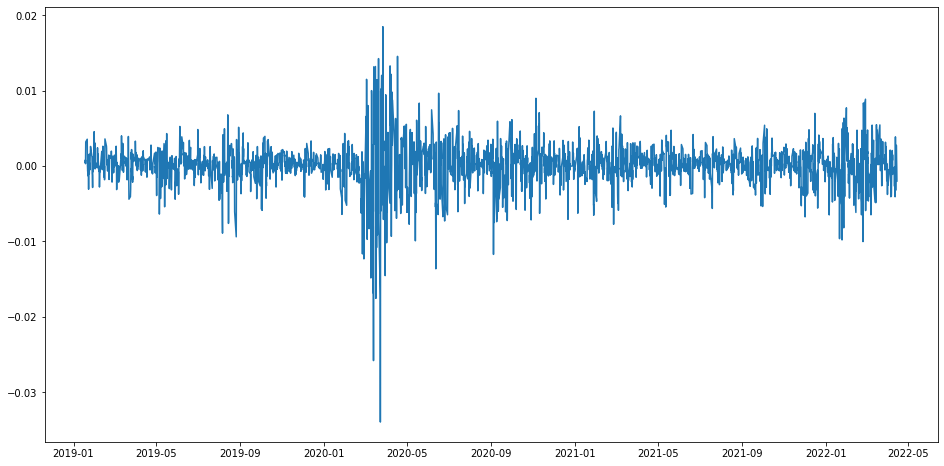

In [12]:
#1 Simple describe() function [in-built]

print(data_open.describe())

# We can see from the results above that the time series for prices is definitely not stationary
# However, the percentage and log returns have a good chance to be stationary (mean returns are realistic and will not change with time. Or at least, haven't yet)

# Let us now try to perform the ADF test (Dickey-Fuller test) to check the stationarity of a time series

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#ADF on % returns: 
print("")
print("ADF on RETURNS:")
print("")
adf_test(data_open['hadf_pct_change'])
print("")
#ADF on log returns: 
print("ADF on LOG RETURNS:")
print("")
adf_test(data_open['hadf_log_return'])
print("")
# Plotting the log returns to double check the stationarity
plt.figure(figsize=(16,8))
plt.plot(data_open['hadf_log_return'])
plt.show()

##### **Null Hypothesis:** Series is non-stationary or series has a unit root.
##### **Alternate Hypothesis:** Series is stationary or series has no unit root.

*   From the test above, we can see that the Test Statistic < (all the critical values) and p-value < 0.05 --> So we reject the Null Hypothesis
*   The p-value is extremely small, which indicates that there is strong evidence in favour of the Alternative Hypothesis
*  The data does look normal to an extent. However, the spike around the center indicates that there is some Positive Kurtosis in the data

#### **NEXT STEPS:** 

* Development of a Classification Model -- Logistic Regression & Random Forest Classifier
* We build these classifiers and see which one works better - 
* We also need to consider which of the classifiers can be integrated well into the strategy

# **BINARY CLASSIFICATION APPROACH using LOGISTIC REGRESSION**

In [13]:
# CONVERTING THE DATA FOR A BINARY CLASSIFICATION PROBLEM:

# Adding a new column for the direction (based on the returns)

NaN = np.nan
data_open['direction'] = NaN
data_open.direction = np.where(data_open['hadf_pct_change'] > 0,   'UP', 'DOWN')

data_open

,open_hadf,open,EMA_1,EMA_5,hadf_pct_change,hadf_log_return,direction
2019-01-18 03:00:00,2638.0625,2643.25,2638.062500,2637.187500,0.000498,0.000498,UP
2019-01-18 07:00:00,2640.21875,2642.25,2640.218750,2638.197917,0.000817,0.000817,UP
2019-01-18 11:00:00,2641.046875,2641.75,2641.046875,2639.147569,0.000314,0.000314,UP
2019-01-18 15:00:00,2644.523438,2651.25,2644.523438,2640.939525,0.001316,0.001315,UP
2019-01-18 19:00:00,2653.011719,2671.00,2653.011719,2644.963590,0.003210,0.003205,UP
...,...,...,...,...,...,...,...
2022-04-14 02:00:00,4432.712245,4445.25,4432.712245,4421.434401,0.002086,0.002083,UP
2022-04-14 06:00:00,4440.887372,4451.50,4440.887372,4427.918725,0.001844,0.001843,UP
2022-04-14 10:00:00,4443.349936,4442.25,4443.349936,4433.062462,0.000555,0.000554,UP
2022-04-14 14:00:00,4440.706218,4429.75,4440.706218,4435.610381,-0.000595,-0.000595,DOWN


Model's Accuracy: 0.812
              precision    recall  f1-score   support

        DOWN       0.83      0.69      0.76       526
          UP       0.80      0.90      0.85       724

    accuracy                           0.81      1250
   macro avg       0.82      0.80      0.80      1250
weighted avg       0.81      0.81      0.81      1250



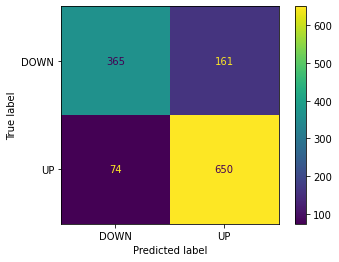

In [14]:
# Splitting the data into test and train: 
X_train, X_test, y_train, y_test = train_test_split(data_open[['open_hadf','EMA_5']], data_open.direction, test_size=0.25)

# Building a model class

model = LogisticRegression()
classifier = model.fit(X_train, y_train)

# Testing the model on X_test (part of the original data): 

y_pred = model.predict(X_test)
print("Model's Accuracy:",model.score(X_test, y_test))
print(classification_report(y_test,y_pred))

# Plotting a confusion matrix 

plot_confusion_matrix(model, X_test, y_test)
plt.show()

Model's Accuracy: 0.7623524704940988
              precision    recall  f1-score   support

        DOWN       0.78      0.71      0.75      2439
          UP       0.75      0.81      0.78      2560

    accuracy                           0.76      4999
   macro avg       0.76      0.76      0.76      4999
weighted avg       0.76      0.76      0.76      4999



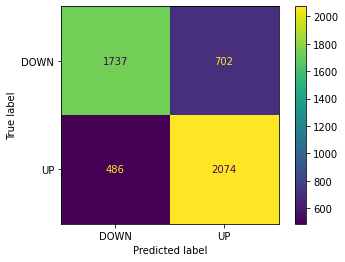

In [15]:
# Testing the model on the 'simulation' dataframe (random simulated data): 

simX_test = simulation.copy(deep=True)
simY_test = simulation.copy(deep=True)

simX_test = simX_test.drop(['direction','hadf_pct_change','hadf_log_return'],1)
simY_test = simY_test.drop(['open_hadf','EMA_5','hadf_pct_change','hadf_log_return'],1)

simulation_pred = model.predict(simX_test)
print("Model's Accuracy:",model.score(simX_test, simY_test))
print(classification_report(simY_test,simulation_pred))

# Plotting a confusion matrix 

plot_confusion_matrix(model, simX_test, simY_test)
plt.show()

# **BINARY CLASSIFICATION APPROACH using a RANDOM FOREST CLASSIFIER**


Model's Accuracy: 0.7488
              precision    recall  f1-score   support

        DOWN       0.72      0.65      0.69       526
          UP       0.76      0.82      0.79       724

    accuracy                           0.75      1250
   macro avg       0.74      0.74      0.74      1250
weighted avg       0.75      0.75      0.75      1250




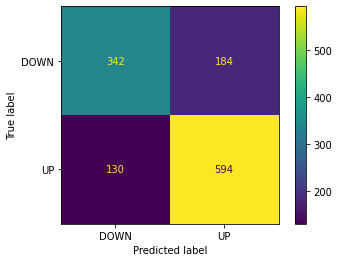

In [16]:
# Building and fitting the model

rf = RandomForestClassifier(max_depth=900, max_samples=2000, n_estimators = 50)
rf.fit(X_train, y_train)

# Testing the model on X_test (part of the original data): 

y_preds = rf.predict(X_test)
print("Model's Accuracy:",rf.score(X_test, y_test))
print(classification_report(y_test,y_preds))
print("")

# Plotting a confusion matrix 
plot_confusion_matrix(rf, X_test, y_test)
plt.show()

Model's Accuracy: 0.5517103420684136
              precision    recall  f1-score   support

        DOWN       0.73      0.13      0.22      2439
          UP       0.53      0.96      0.69      2560

    accuracy                           0.55      4999
   macro avg       0.63      0.54      0.45      4999
weighted avg       0.63      0.55      0.46      4999



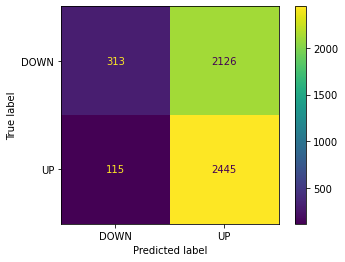

In [18]:
# Testing the model on the 'simulation' dataframe (random simulated data): 


simX_test = simulation.copy(deep=True)
simY_test = simulation.copy(deep=True)

simX_test = simX_test.drop(['direction','hadf_pct_change','hadf_log_return'],1)
simY_test = simY_test.drop(['open_hadf','EMA_5','hadf_pct_change','hadf_log_return'],1)

simulation_preds = rf.predict(simX_test)
print("Model's Accuracy:",rf.score(simX_test, simY_test))
print(classification_report(simY_test,simulation_preds))

# Plotting a confusion matrix 

plot_confusion_matrix(rf, simX_test, simY_test)
plt.show()

The results from classification models show us that in our case, Logistic Regression would be a better choice 


In [19]:
# Let us now add another column for the momentum overlay:

#pd.set_option('display.max_rows', 100)

data_open['long'] = np.where(data_open.EMA_1 > data_open.EMA_5, 1,0)
data_open['Signal'] = data_open['long'].diff()

# We need to shift the signals one step down. 
# For instance, if the signal was -1 on Jan 6th, 2022, the trade will be made at the open price of Jan 7th, 2022
# Therefore, we need to shift the signals one step down

data_open['Signal'] = data_open['Signal'].shift(1)
data_open

,open_hadf,open,EMA_1,EMA_5,hadf_pct_change,hadf_log_return,direction,long,Signal
2019-01-18 03:00:00,2638.0625,2643.25,2638.062500,2637.187500,0.000498,0.000498,UP,1,NaN
2019-01-18 07:00:00,2640.21875,2642.25,2640.218750,2638.197917,0.000817,0.000817,UP,1,NaN
2019-01-18 11:00:00,2641.046875,2641.75,2641.046875,2639.147569,0.000314,0.000314,UP,1,0.0
2019-01-18 15:00:00,2644.523438,2651.25,2644.523438,2640.939525,0.001316,0.001315,UP,1,0.0
2019-01-18 19:00:00,2653.011719,2671.00,2653.011719,2644.963590,0.003210,0.003205,UP,1,0.0
...,...,...,...,...,...,...,...,...,...
2022-04-14 02:00:00,4432.712245,4445.25,4432.712245,4421.434401,0.002086,0.002083,UP,1,1.0
2022-04-14 06:00:00,4440.887372,4451.50,4440.887372,4427.918725,0.001844,0.001843,UP,1,0.0
2022-04-14 10:00:00,4443.349936,4442.25,4443.349936,4433.062462,0.000555,0.000554,UP,1,0.0
2022-04-14 14:00:00,4440.706218,4429.75,4440.706218,4435.610381,-0.000595,-0.000595,DOWN,1,0.0


In [20]:
#Creating another dataframe to do some testing with signals

# Here we are integrating the moving average signals along with the direction signals

opens = data_open.copy(deep=True)

condition = [((opens['Signal']==1) & (opens['direction']=='UP')),
             ((opens['Signal']==1) & (opens['direction']=='DOWN')),
             ((opens['Signal']==0) & (opens['direction']=='UP')),
             ((opens['Signal']==0) & (opens['direction']=='DOWN')),
             ((opens['Signal']==-1) & (opens['direction']=='UP')),
             ((opens['Signal']==-1) & (opens['direction']=='DOWN'))]

values = [1,0,0,0,0,-1]

opens['momentum_signal'] = np.select(condition,values)
opens

,open_hadf,open,EMA_1,EMA_5,hadf_pct_change,hadf_log_return,direction,long,Signal,momentum_signal
2019-01-18 03:00:00,2638.0625,2643.25,2638.062500,2637.187500,0.000498,0.000498,UP,1,NaN,0
2019-01-18 07:00:00,2640.21875,2642.25,2640.218750,2638.197917,0.000817,0.000817,UP,1,NaN,0
2019-01-18 11:00:00,2641.046875,2641.75,2641.046875,2639.147569,0.000314,0.000314,UP,1,0.0,0
2019-01-18 15:00:00,2644.523438,2651.25,2644.523438,2640.939525,0.001316,0.001315,UP,1,0.0,0
2019-01-18 19:00:00,2653.011719,2671.00,2653.011719,2644.963590,0.003210,0.003205,UP,1,0.0,0
...,...,...,...,...,...,...,...,...,...,...
2022-04-14 02:00:00,4432.712245,4445.25,4432.712245,4421.434401,0.002086,0.002083,UP,1,1.0,1
2022-04-14 06:00:00,4440.887372,4451.50,4440.887372,4427.918725,0.001844,0.001843,UP,1,0.0,0
2022-04-14 10:00:00,4443.349936,4442.25,4443.349936,4433.062462,0.000555,0.000554,UP,1,0.0,0
2022-04-14 14:00:00,4440.706218,4429.75,4440.706218,4435.610381,-0.000595,-0.000595,DOWN,1,0.0,0


# **Integration: Applying ML Model on the 'opens' dataframe and predicting values**

* These predicted values will be added to another column -- 'ml_predict'



In [21]:
# actual price data for the ML model
live_px_data = opens.copy(deep=True)

# removing all columns except 'open_hadf' and 'EMA_5'
live_px_data = live_px_data.drop(['open','EMA_1','direction','hadf_pct_change','hadf_log_return','long','Signal','momentum_signal'],1)

# using the ML model that we created earlier to make predictions
ml_pred = model.predict(live_px_data)

# converting the numpy array to a pandas dataframe

ml_dataframe = pd.DataFrame(ml_pred, columns=['ml_predict'])

# assigning the same index to the predictions dataframe
ml_dataframe.index = opens.index
#concatenating the ml_dataframe to opens dataframe

opens = pd.concat([opens,ml_dataframe],axis=1)
opens

,open_hadf,open,EMA_1,EMA_5,hadf_pct_change,hadf_log_return,direction,long,Signal,momentum_signal,ml_predict
2019-01-18 03:00:00,2638.0625,2643.25,2638.062500,2637.187500,0.000498,0.000498,UP,1,NaN,0,UP
2019-01-18 07:00:00,2640.21875,2642.25,2640.218750,2638.197917,0.000817,0.000817,UP,1,NaN,0,UP
2019-01-18 11:00:00,2641.046875,2641.75,2641.046875,2639.147569,0.000314,0.000314,UP,1,0.0,0,UP
2019-01-18 15:00:00,2644.523438,2651.25,2644.523438,2640.939525,0.001316,0.001315,UP,1,0.0,0,UP
2019-01-18 19:00:00,2653.011719,2671.00,2653.011719,2644.963590,0.003210,0.003205,UP,1,0.0,0,UP
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-14 02:00:00,4432.712245,4445.25,4432.712245,4421.434401,0.002086,0.002083,UP,1,1.0,1,UP
2022-04-14 06:00:00,4440.887372,4451.50,4440.887372,4427.918725,0.001844,0.001843,UP,1,0.0,0,UP
2022-04-14 10:00:00,4443.349936,4442.25,4443.349936,4433.062462,0.000555,0.000554,UP,1,0.0,0,UP
2022-04-14 14:00:00,4440.706218,4429.75,4440.706218,4435.610381,-0.000595,-0.000595,DOWN,1,0.0,0,UP


# **FINAL INTEGRATION OF ML MODEL WITH MOMENTUM FILTER**

In [22]:
fin_mod = opens.copy(deep=True)

conditions = [((fin_mod['momentum_signal']==1) & (fin_mod['ml_predict']=='UP')),
             ((fin_mod['momentum_signal']==1) & (fin_mod['ml_predict']=='DOWN')),
             ((fin_mod['momentum_signal']==0) & (fin_mod['ml_predict']=='UP')),
             ((fin_mod['momentum_signal']==0) & (fin_mod['ml_predict']=='DOWN')),
             ((fin_mod['momentum_signal']==-1) & (fin_mod['ml_predict']=='UP')),
             ((fin_mod['momentum_signal']==-1) & (fin_mod['ml_predict']=='DOWN'))]

values_fin = [1,0,0,0,0,-1]

fin_mod['final_signal'] = np.select(conditions,values_fin)
final_data = fin_mod.drop(['EMA_1','hadf_pct_change','hadf_log_return','direction','long','Signal'],1)

# displaying the final data with only necesary columns:

final_data

,open_hadf,open,EMA_5,momentum_signal,ml_predict,final_signal
2019-01-18 03:00:00,2638.0625,2643.25,2637.187500,0,UP,0
2019-01-18 07:00:00,2640.21875,2642.25,2638.197917,0,UP,0
2019-01-18 11:00:00,2641.046875,2641.75,2639.147569,0,UP,0
2019-01-18 15:00:00,2644.523438,2651.25,2640.939525,0,UP,0
2019-01-18 19:00:00,2653.011719,2671.00,2644.963590,0,UP,0
...,...,...,...,...,...,...
2022-04-14 02:00:00,4432.712245,4445.25,4421.434401,1,UP,1
2022-04-14 06:00:00,4440.887372,4451.50,4427.918725,0,UP,0
2022-04-14 10:00:00,4443.349936,4442.25,4433.062462,0,UP,0
2022-04-14 14:00:00,4440.706218,4429.75,4435.610381,0,UP,0


# **BACKESTING**

* Implementation of a bactesting engine for the combined model
* Utilizes the VectorBT library

In [23]:
# Initializing the portfolio settings for VectorBT

# 1. We will be using the HADF data because it generates signals with little noise

px = pd.to_numeric(final_data['open_hadf'],errors='coerce')

# 2. Setting the initial portfolio cash to 100,000 USD and Trade Size = 1 contract

vbt.settings.portfolio['init_cash'] = 100000.  
vbt.settings.portfolio['size'] = 1

# Initializing moving averages for VectorBT

fast_ma = vbt.MA.run(px, 1, short_name='fast')
slow_ma = vbt.MA.run(px, 5, short_name='slow')

# Generate LONG crossover signals
dmac_entries_long = fast_ma.ma_crossed_above(slow_ma)
dmac_exits_long = fast_ma.ma_crossed_below(slow_ma)

# Build partfolio, which internally calculates the equity curve

dmac_long_pf = vbt.Portfolio.from_signals(px, dmac_entries_long, dmac_exits_long)

# Storing the trades/trade log in a DataFrame

df_test = pd.DataFrame(dmac_long_pf.trades.records)

# Modifying the trades in the DataFrame to adjust for Heikin Ashi Factor and Slippage

df_mod = df_test.copy(deep=True)
slippage = 8
df_mod['entry_price'] = df_mod['entry_price'] + slippage
df_mod['exit_price'] = df_mod['exit_price'] - slippage
df_mod['pnl'] = df_mod['exit_price']-df_mod['entry_price']

# **PnL Statistics - LONG Signals on E-mini S&P 500 Futures**

* Profit/Loss analysis of LONG signal trades and overall model on the E-mini S&P 500 futures

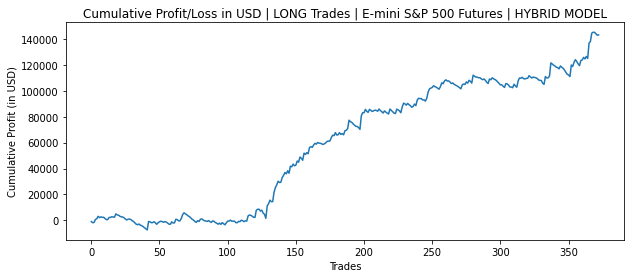

In [26]:
# Equity curve for LONG Trade Signals

df_mod['cumulative_pnl_points'] = pd.Series(dtype='float')

for i in range(len(df_mod)):
  if i == 0:
    df_mod['cumulative_pnl_points'][i] = df_mod['pnl'][i]
  else:
    df_mod['cumulative_pnl_points'][i] = df_mod['pnl'][i] + df_mod['cumulative_pnl_points'][i-1]

df_mod['cumulative_pnl_usd'] = df_mod['cumulative_pnl_points']*50.0
df_mod['cumulative_pnl_usd'].plot(figsize=(10,4),xlabel='Trades',ylabel='Cumulative Profit (in USD)',title='Cumulative Profit/Loss in USD | LONG Trades | E-mini S&P 500 Futures | HYBRID MODEL')

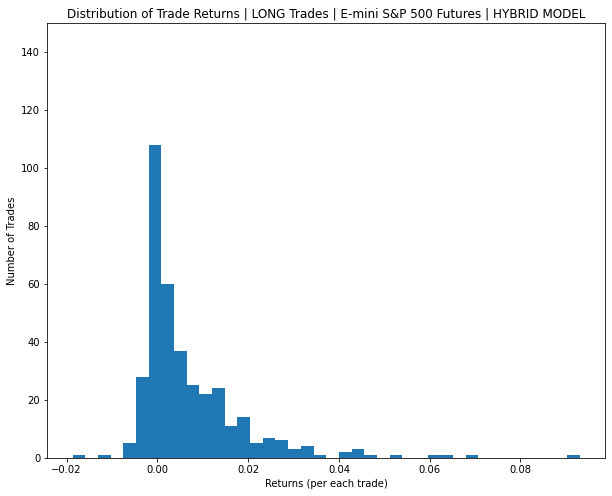

In [27]:
# Distribution of Returns for LONG Trade Signals

df_results = df_mod.drop(['col','entry_idx','entry_fees','entry_idx','exit_fees','direction','parent_id'],1)

x = df_results['return']
plt.figure(figsize=(10,8))
plt.hist(x, bins=40)
plt.xlabel('Returns (per each trade)')
plt.ylabel('Number of Trades')
plt.ylim(0,150)
plt.title('Distribution of Trade Returns | LONG Trades | E-mini S&P 500 Futures | HYBRID MODEL')
plt.show()

In [28]:
# Calculating the total POINTS the strategy made (not in dollars, since we are using futures)

total_long_pts = df_mod['pnl'].sum()

# Calculating the starting and ending price of the time series to compute the Buy-and-Hold return 

starting_price = int(data_open['open'][0])
current_price = int(data_open['open'][-1])

# PRINT FINAL TRADE AND PORTFOLIO STATISTICS

# size of each trade and other stats
trade_size = 1
initial_capital = 100000
long_pnl = total_long_pts*50*trade_size
buyhold_pnl = (current_price-starting_price)*50*trade_size
strat_pct_return = float(100*((long_pnl+initial_capital)-initial_capital)/(initial_capital))
buyhold_pct_return = float(100*((initial_capital+buyhold_pnl)-initial_capital)/(initial_capital))


print("Trade Size: 1 contract")
print("Total Number of Completed Trades: ",df_test['status'].sum(axis=0,skipna=True))
print("Total LONG Pts: ",total_long_pts)
print("")
# PnL Statistics -- Strategy vs Buy-and-Hold the Underlying
print("***** PnL Since Inception *****")
print("")
print("LONG Trades PnL: $",long_pnl)
print("Portfolio Value at the End of Hybrid Strategy: $",int(initial_capital+long_pnl))
print("Model Return: ",strat_pct_return,"%")
print("")
print("***** Benchmark Buy & Hold PnL *****")
print("")
print("Buy & Hold PnL: $",buyhold_pnl)
print("Portfolio Value at the End of Buy and Hold Strategy: $",int(initial_capital+buyhold_pnl))
print("Buy and Hold Strategy Return: ",buyhold_pct_return,"%")
print("")

Trade Size: 1 contract
Total Number of Completed Trades:  373
Total LONG Pts:  2864.7547112305497

***** PnL Since Inception *****

LONG Trades PnL: $ 143237.7355615275
Portfolio Value at the End of Hybrid Strategy: $ 243237
Model Return:  143.23773556152747 %

***** Benchmark Buy & Hold PnL *****

Buy & Hold PnL: $ 88900
Portfolio Value at the End of Buy and Hold Strategy: $ 188900
Buy and Hold Strategy Return:  88.9 %



LONG Signals PnL Stats (in $)

count      373.000000
mean       384.015377
std       2026.975542
min      -3049.131706
25%       -892.565288
50%       -298.101464
75%       1104.123976
max      11806.633809
Name: pnl, dtype: float64



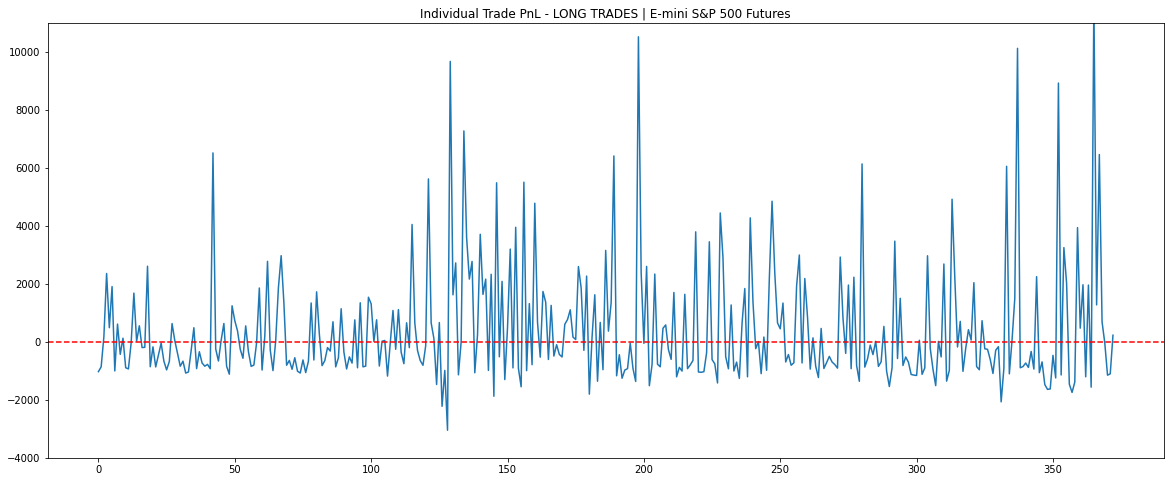

In [29]:
# LONG Trade Signal PnL Statistics

print("LONG Signals PnL Stats (in $)")
print("")
print((50*trade_size*df_mod['pnl']).describe())
print("")

ymin = -4000
ymax = 11000

plt.figure(figsize=(20,8))
plt.plot(df_mod['pnl']*50)
plt.axhline(y=0, linestyle='dashed', color='red')
x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,ymin,ymax))
plt.title("Individual Trade PnL - LONG TRADES | E-mini S&P 500 Futures")
plt.show()

# **PnL Statistics - SHORT Signals on E-mini S&P 500 Futures**

* Profit/Loss analysis of SHORT signal trades and overall model on the E-mini S&P 500 futures

In [30]:
# SHORT Trade Signals

fast_ma_short = vbt.MA.run(px, 1, short_name='fast')
slow_ma_short = vbt.MA.run(px, 5, short_name='slow')
dmac_entries_short = fast_ma_short.ma_crossed_below(slow_ma_short)
dmac_exits_short = fast_ma_short.ma_crossed_above(slow_ma_short)

# Build portfolio, which internally calculates the equity curve

dmac_short_pf = vbt.Portfolio.from_signals(px, dmac_entries_short, dmac_exits_short)

# Storing the trades/trade log in a DataFrame

df_test_short = pd.DataFrame(dmac_short_pf.trades.records)

# Modifying the trades in the DataFrame to adjust for Heikin Ashi Factor and Slippage

df_mod_short = df_test_short.copy(deep=True)
slippage_short = 7
df_mod_short['entry_price'] = df_mod_short['entry_price'] - slippage_short
df_mod_short['exit_price'] = df_mod_short['exit_price'] + slippage_short

df_mod_short['pnl'] = df_mod_short['exit_price']-df_mod_short['entry_price']
df_mod_short['pnl'] = -1*df_mod_short['pnl']

# Calculating the total POINTS the strategy made (not in dollars, since we are using futures)

total_short_pts = df_mod_short['pnl'].sum()
short_trade_size = 1
short_pnl = total_short_pts*50*short_trade_size

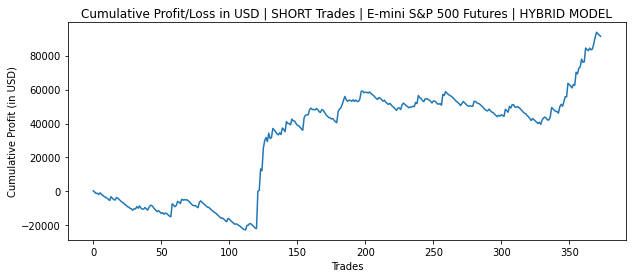

In [31]:
# Plotting the Equity Curve for SHORT Trade Signals

df_mod_short['cumulative_pnl_points'] = pd.Series(dtype='float')

for i in range(len(df_mod_short)):
  if i == 0:
    df_mod_short['cumulative_pnl_points'][i] = df_mod_short['pnl'][i]
  else:
    df_mod_short['cumulative_pnl_points'][i] = df_mod_short['pnl'][i] + df_mod_short['cumulative_pnl_points'][i-1]

df_mod_short['cumulative_pnl_usd'] = df_mod_short['cumulative_pnl_points']*50.0
df_mod_short['cumulative_pnl_usd'].plot(figsize=(10,4),xlabel='Trades',ylabel='Cumulative Profit (in USD)',title='Cumulative Profit/Loss in USD | SHORT Trades | E-mini S&P 500 Futures | HYBRID MODEL')


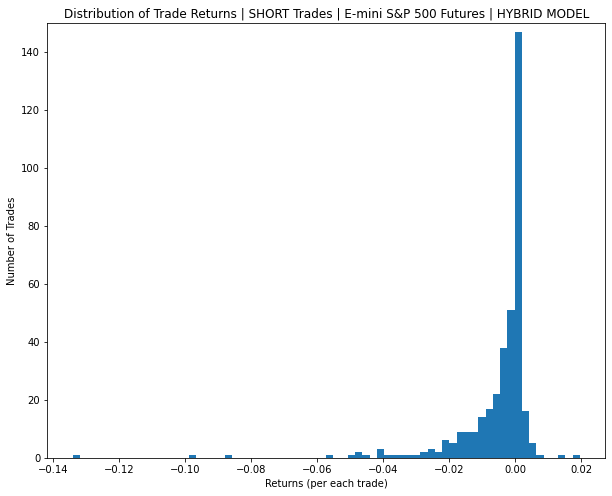

In [32]:
# Distribution of Returns for SHORT Trade Signals

y = df_mod_short['return']
plt.figure(figsize=(10,8))
plt.hist(y, bins=70)
plt.xlabel('Returns (per each trade)')
plt.ylabel('Number of Trades')
plt.ylim(0,150)
plt.title('Distribution of Trade Returns | SHORT Trades | E-mini S&P 500 Futures | HYBRID MODEL')
plt.show()

SHORT Signals PnL Stats (in $)

count      374.000000
mean       244.221259
std       2223.263388
min      -3100.607950
25%       -802.239418
50%       -571.847443
75%        516.583972
max      21995.149531
Name: pnl, dtype: float64



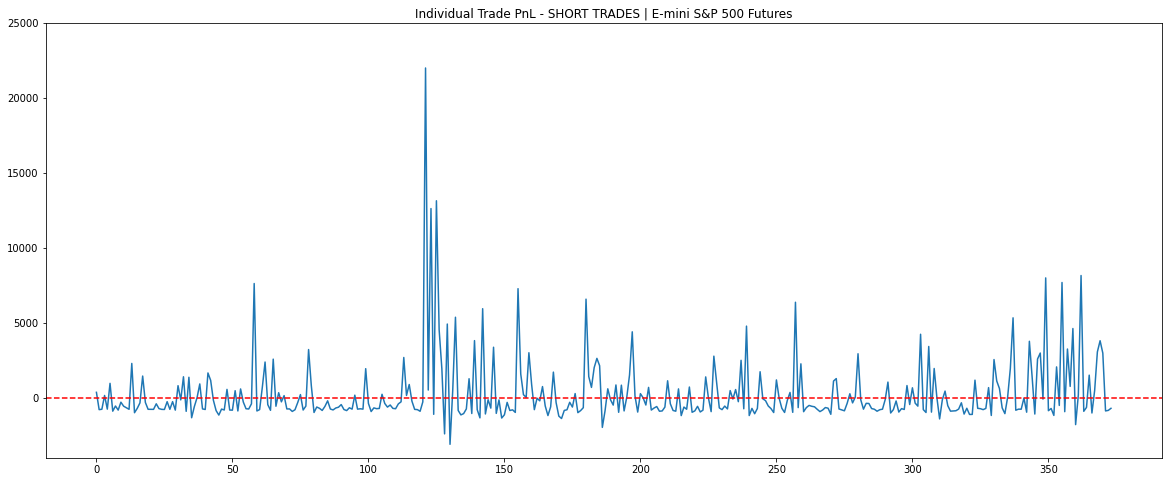

In [33]:
# SHORT Trade Signal PnL Statistics

print("SHORT Signals PnL Stats (in $)")
print("")
print((50*trade_size*df_mod_short['pnl']).describe())
print("")

ymin = -4000
ymax = 25000

plt.figure(figsize=(20,8))
plt.plot(df_mod_short['pnl']*50)
#plt.axhline(y=100, linestyle='dashed', color='black')
plt.axhline(y=0, linestyle='dashed', color='red') #y=150 for NQ 
#plt.axhline(y=300, linestyle='dashed', color='blue')
x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,ymin,ymax))
plt.title("Individual Trade PnL - SHORT TRADES | E-mini S&P 500 Futures")
plt.show()

# **MODEL RESULTS ON EURODOLLAR FUTURES**

##### Now we will test our final model and its robustness on the Eurodollar Futures market. This market has a completely different microstructure and moves very slowly

In [34]:
ge = tv.get_hist(symbol='GE',exchange='CME',interval=Interval.in_weekly,n_bars=5000,fut_contract=1)
ge_px = ge.drop(['symbol','volume'],1) #drop the columns for symbol and volume (not needed in the analysis)

#Converting candlesticks to Heikin Ashi
hadf = heikin_ashi(ge_px) 

data_open_ge = pd.DataFrame(hadf['open'])
data_open_ge.columns = ['open_hadf']
data_open_ge['open'] = pd.DataFrame(ge_px['open'])

# BACKTESTING STUFF

#portfolio settings for VectorBT

px_ge = pd.to_numeric(data_open_ge['open_hadf'],errors='coerce')
vbt.settings.portfolio['init_cash'] = 100000.  # $100000
vbt.settings.portfolio['size'] = 1

# Moving averages for VectorBT

fast_ma_long_ge = vbt.MA.run(px_ge, 1, short_name='fast')
slow_ma_long_ge = vbt.MA.run(px_ge, 5, short_name='slow')  

# Generate LONG crossover signals
dmac_entries_long_ge = fast_ma_long_ge.ma_crossed_above(slow_ma_long_ge)
dmac_exits_long_ge = fast_ma_long_ge.ma_crossed_below(slow_ma_long_ge)

# Build partfolio, which internally calculates the equity curve

# Volume is set to np.inf by default to buy/sell everything
# You don't have to pass freq here because our data is already perfectly time-indexed
dmac_long_pf_ge = vbt.Portfolio.from_signals(px_ge, dmac_entries_long_ge, dmac_exits_long_ge)                                            

# Storing the trades/trade log in a DataFrame

df_test_ge = pd.DataFrame(dmac_long_pf_ge.trades.records)

# Modifying the trades in the DataFrame to adjust for Heikin Ashi Factor and Slippage

df_mod_ge = df_test_ge.copy(deep=True)
slippage_long_ge = 0
df_mod_ge['entry_price'] = df_mod_ge['entry_price'] + slippage_long_ge
df_mod_ge['exit_price'] = df_mod_ge['exit_price'] - slippage_long_ge
df_mod_ge['pnl'] = df_mod_ge['exit_price']-df_mod_ge['entry_price']

# Calculating the total POINTS the strategy made (not in dollars, since we are using futures)

total_long_pts_ge = df_mod_ge['pnl'].sum()
trade_size_ge = 1
long_pnl_ge = total_long_pts_ge*2500*trade_size_ge

# **PnL Statistics - LONG Signals on Eurodollar Futures**

* Profit/Loss analysis of LONG signal trades and overall model on the Eurodollar futures



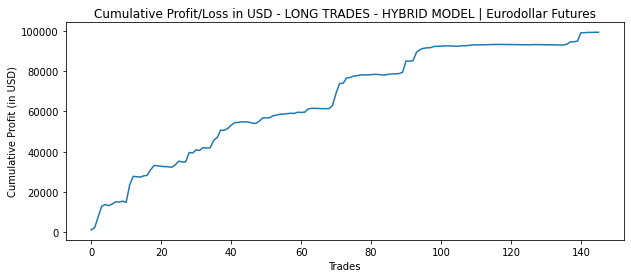

In [36]:
# Plotting the Equity Curve for LONG Trade Signals - Eurodollar futures

df_mod_ge['cumulative_pnl_points'] = pd.Series(dtype='float')

for i in range(len(df_mod_ge)):
  if i == 0:
    df_mod_ge['cumulative_pnl_points'][i] = df_mod_ge['pnl'][i]
  else:
    df_mod_ge['cumulative_pnl_points'][i] = df_mod_ge['pnl'][i] + df_mod_ge['cumulative_pnl_points'][i-1]

df_mod_ge['cumulative_pnl_usd'] = df_mod_ge['cumulative_pnl_points']*2500.0
df_mod_ge['cumulative_pnl_usd'].plot(figsize=(10,4),xlabel='Trades',ylabel='Cumulative Profit (in USD)',title='Cumulative Profit/Loss in USD - LONG TRADES - HYBRID MODEL | Eurodollar Futures')

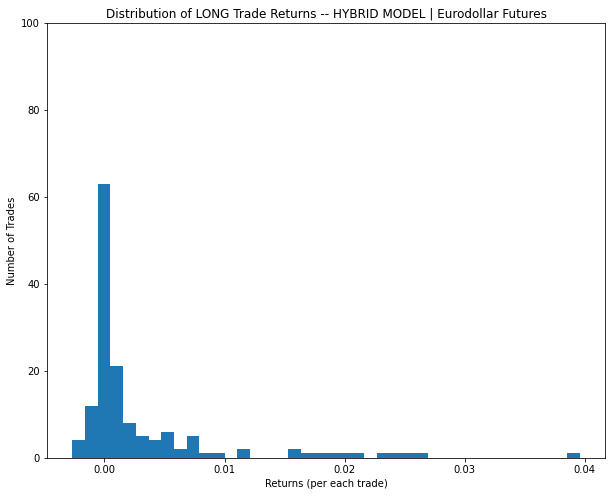

In [37]:
# Plotting the distribution of returns for LONG Trade Signals - Eurodollar Futures

x_ge = df_mod_ge['return']
plt.figure(figsize=(10,8))
plt.hist(x_ge, bins=40)
plt.xlabel('Returns (per each trade)')
plt.ylabel('Number of Trades')
plt.ylim(0,100)
plt.title('Distribution of LONG Trade Returns -- HYBRID MODEL | Eurodollar Futures')
plt.show()

Trade Size: 1 contract

Total LONG Pts:  39.75622194093303
LONG Trades Pnl:  99390.55485233257 USD

PnL Stats for LONG Eurodollar (in $)

count     146.000000
mean      680.757225
std      1480.516361
min      -588.878919
25%       -26.442965
50%        73.603026
75%       664.536320
max      8641.109693
Name: pnl, dtype: float64



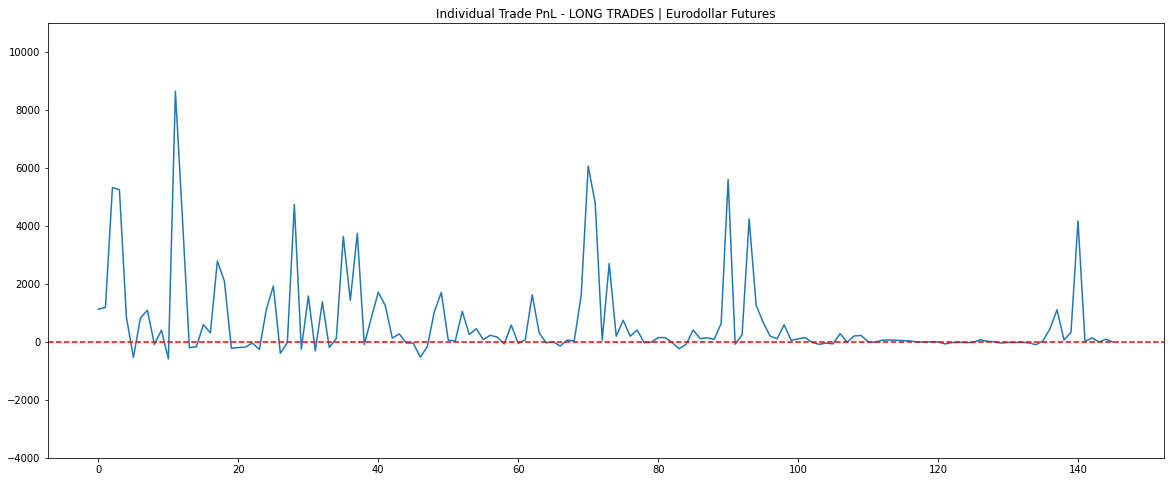

In [38]:
# LONG Trade Signal PnL Statistics - Eurodollar futures


import matplotlib.pyplot as plt
print("Trade Size:",trade_size_ge, "contract")
print("")
# total points captured using LONG trades (adjusted for commissions and slippage)
print("Total LONG Pts: ",total_long_pts_ge)
print("LONG Trades Pnl: ", long_pnl_ge,"USD")
print("")

# general trade analysis

print("PnL Stats for LONG Eurodollar (in $)")
print("")
print((2500*trade_size_ge*df_mod_ge['pnl']).describe())
print("")

ymin = -4000
ymax = 11000

plt.figure(figsize=(20,8))
plt.plot(df_mod_ge['pnl']*2500)
plt.axhline(y=0, linestyle='dashed', color='red')
x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,ymin,ymax))
plt.title("Individual Trade PnL - LONG TRADES | Eurodollar Futures")
plt.show()

# **PnL Statistics - SHORT Signals on Eurodollar Futures**

* Profit/Loss analysis of SHORT signal trades and overall model on the Eurodollar futures



In [40]:
# Moving averages for VectorBT

fast_ma_short_ge = vbt.MA.run(px_ge, 1, short_name='fast')
slow_ma_short_ge = vbt.MA.run(px_ge, 5, short_name='slow')


# Generate SHORT crossover signals
dmac_entries_short_ge = fast_ma_short_ge.ma_crossed_below(slow_ma_short_ge)
dmac_exits_short_ge = fast_ma_short_ge.ma_crossed_above(slow_ma_short_ge)

# Build portfolio, which internally calculates the equity curve

dmac_short_pf_ge = vbt.Portfolio.from_signals(px_ge, dmac_entries_short_ge, dmac_exits_short_ge)

# Storing the trades/trade log in a DataFrame

df_test_short_ge = pd.DataFrame(dmac_short_pf_ge.trades.records)

# Modifying the trades in the DataFrame to adjust for Heikin Ashi Factor and Slippage


df_mod_short_ge = df_test_short_ge.copy(deep=True)
slippage_short_ge = 0
df_mod_short_ge['entry_price'] = df_mod_short_ge['entry_price'] - slippage_short_ge
df_mod_short_ge['exit_price'] = df_mod_short_ge['exit_price'] + slippage_short_ge

df_mod_short_ge['pnl'] = df_mod_short_ge['exit_price']-df_mod_short_ge['entry_price']
df_mod_short_ge['pnl'] = -1*df_mod_short_ge['pnl']

# Calculating the total POINTS the strategy made (not in dollars, since we are using futures)

total_short_pts_ge = df_mod_short_ge['pnl'].sum()
short_trade_size_ge = 1
short_pnl_ge = total_short_pts_ge*2500*short_trade_size_ge

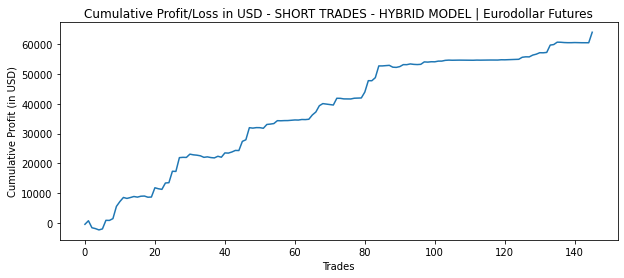

In [41]:
# Plotting the Equity Curve for LONG Trade Signals - Eurodollar futures

df_mod_short_ge['cumulative_pnl_points'] = pd.Series(dtype='float')

for i in range(len(df_mod_short_ge)):
  if i == 0:
    df_mod_short_ge['cumulative_pnl_points'][i] = df_mod_short_ge['pnl'][i]
  else:
    df_mod_short_ge['cumulative_pnl_points'][i] = df_mod_short_ge['pnl'][i] + df_mod_short_ge['cumulative_pnl_points'][i-1]

df_mod_short_ge['cumulative_pnl_usd'] = df_mod_short_ge['cumulative_pnl_points']*2500.0

df_mod_short_ge['cumulative_pnl_usd'].plot(figsize=(10,4),xlabel='Trades',ylabel='Cumulative Profit (in USD)',title='Cumulative Profit/Loss in USD - SHORT TRADES - HYBRID MODEL | Eurodollar Futures')

Trade Size: 1 contract

Total SHORT Pts:  25.602881191511955
SHORT Trades Pnl:  64007.20297877989 USD

PnL Stats for SHORT Eurodollar Signals (in $)

count     146.000000
mean      438.405500
std      1065.529370
min     -2342.437318
25%       -31.353150
50%        44.476477
75%       365.557746
max      4621.012762
Name: pnl, dtype: float64



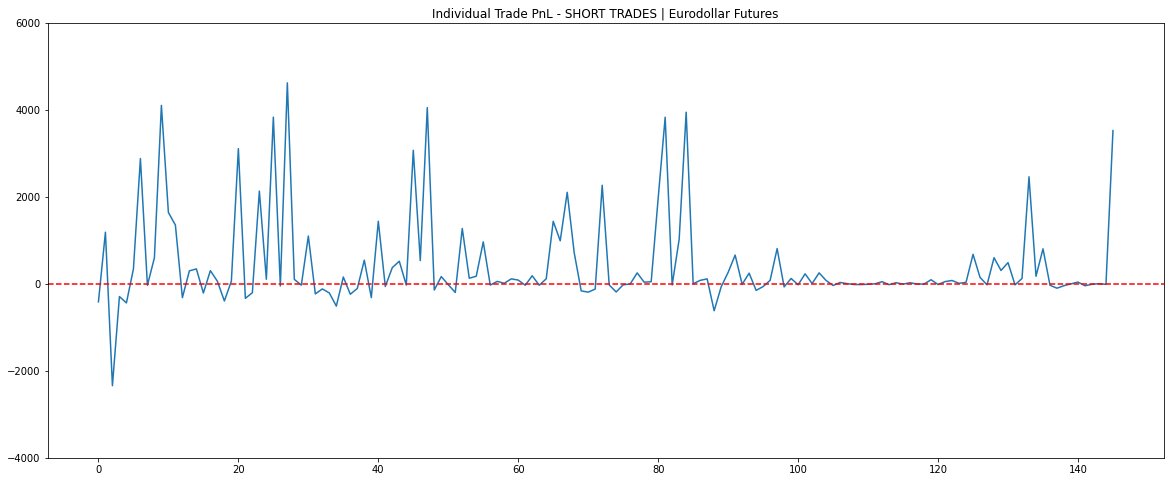

In [43]:
# SHORT Trade Signal PnL Statistics - Eurodollar futures

print("Trade Size:",short_trade_size_ge, "contract")
print("")
# total points captured using LONG trades (adjusted for commissions and slippage)
print("Total SHORT Pts: ",total_short_pts_ge)
print("SHORT Trades Pnl: ", short_pnl_ge,"USD")
print("")

# general trade analysis
print("PnL Stats for SHORT Eurodollar Signals (in $)")
print("")
print((2500*short_trade_size_ge*df_mod_short_ge['pnl']).describe())
print("")

ymin = -4000
ymax = 6000

plt.figure(figsize=(20,8))
plt.plot(df_mod_short_ge['pnl']*2500)
plt.axhline(y=0, linestyle='dashed', color='red') #y=150 for NQ 
plt.title("Individual Trade PnL - SHORT TRADES | Eurodollar Futures")
x1,x2,y1,y2 = plt.axis()  
plt.axis((x1,x2,ymin,ymax))
plt.show()


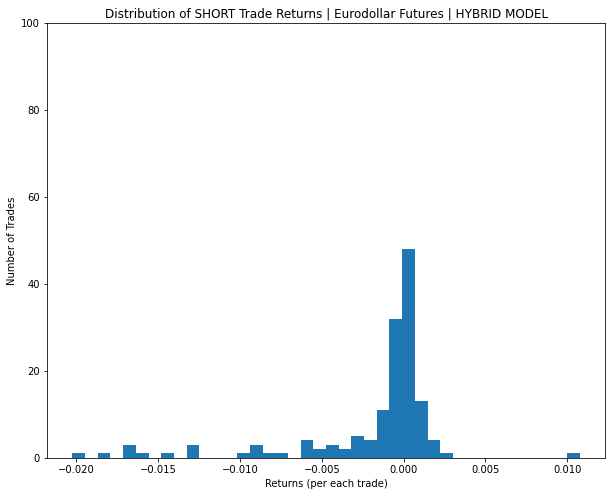

In [44]:
# Plotting the distribution of returns for SHORT Trade Signals - Eurodollar Futures


y_ge = df_mod_short_ge['return']
plt.figure(figsize=(10,8))
plt.hist(y_ge, bins=40)
plt.xlabel('Returns (per each trade)')
plt.ylabel('Number of Trades')
plt.ylim(0,100)
plt.title('Distribution of SHORT Trade Returns | Eurodollar Futures | HYBRID MODEL')
plt.show()